Train Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating       

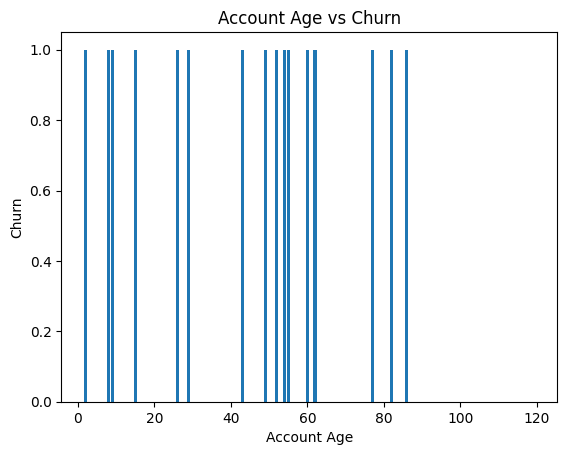

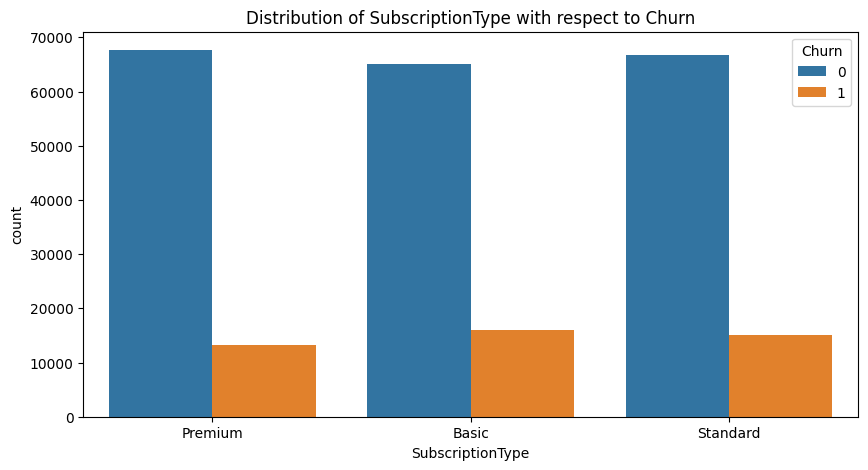

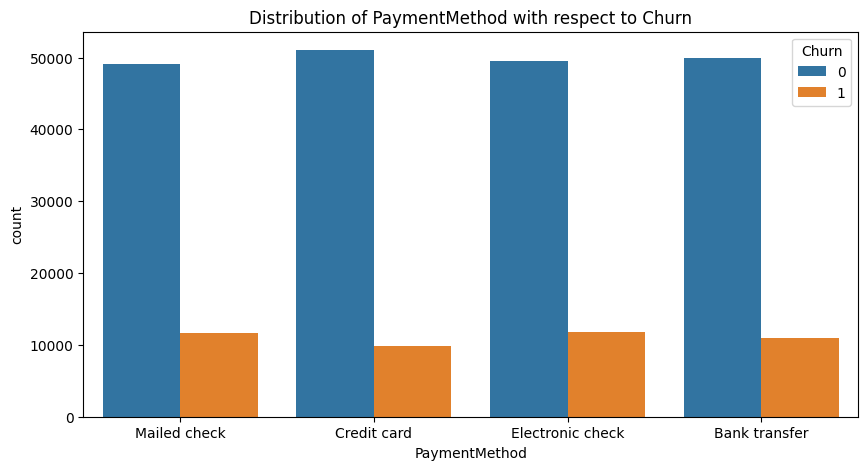

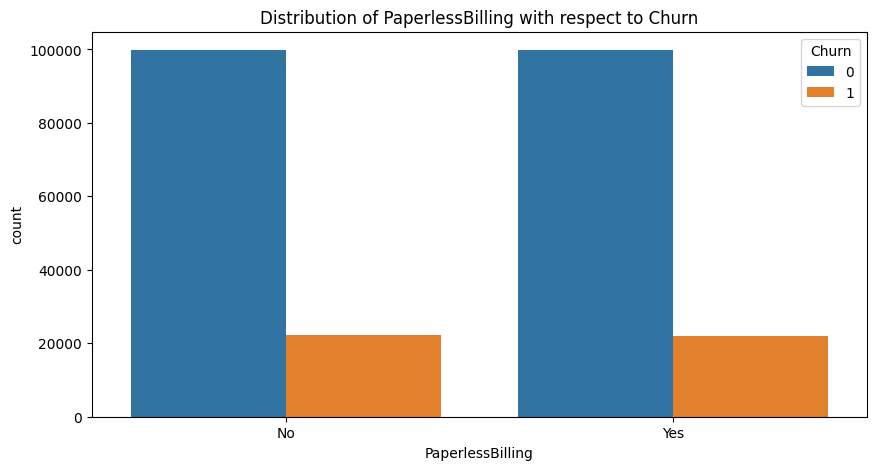

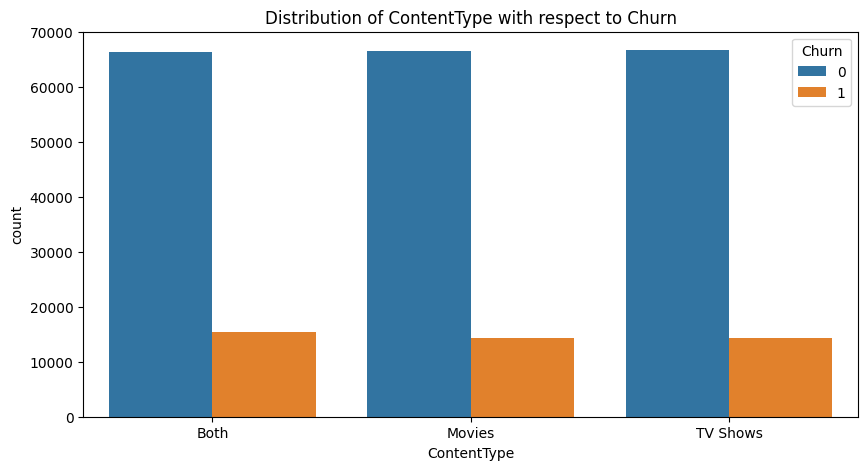

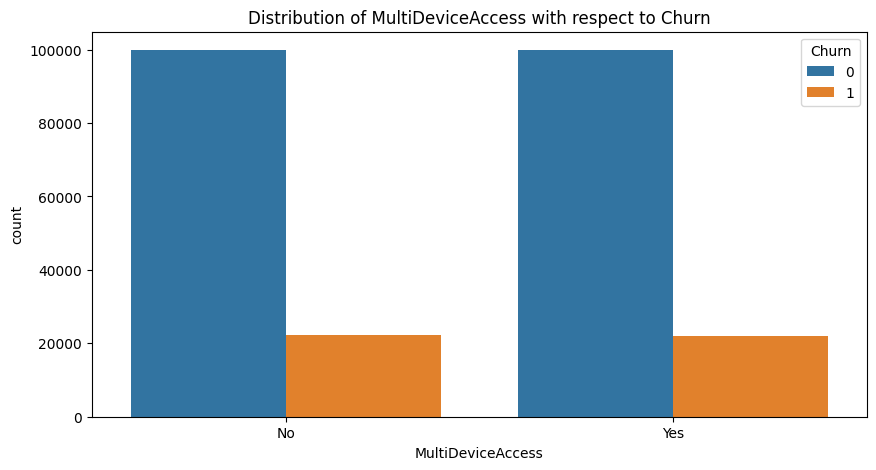

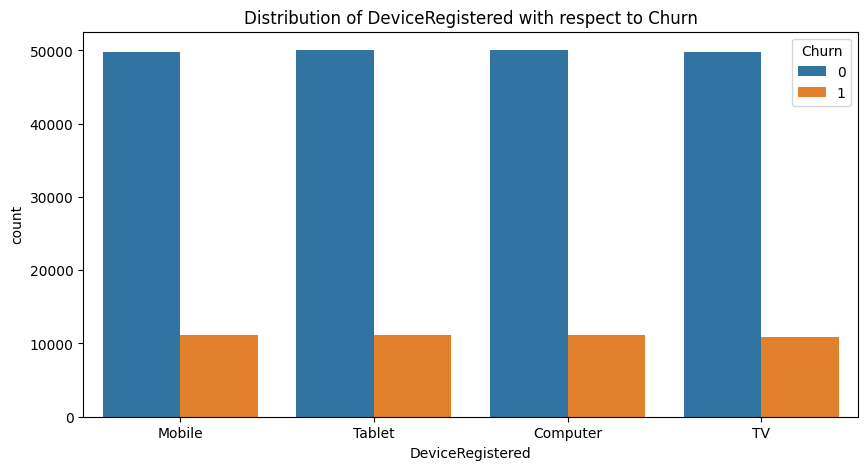

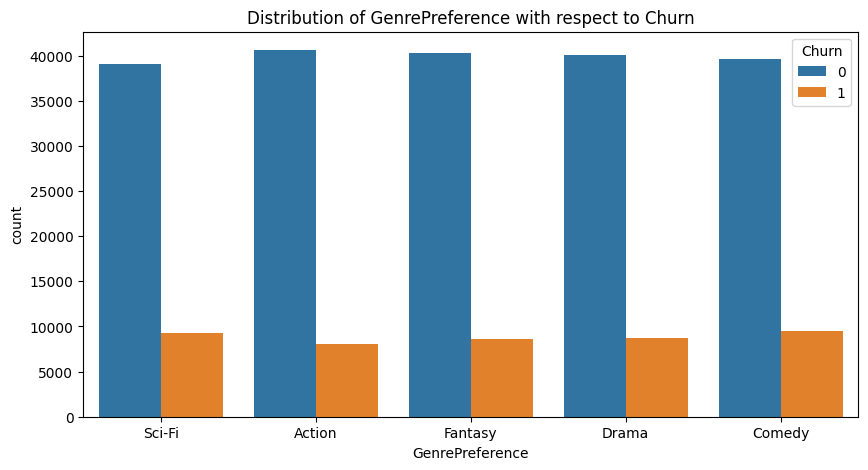

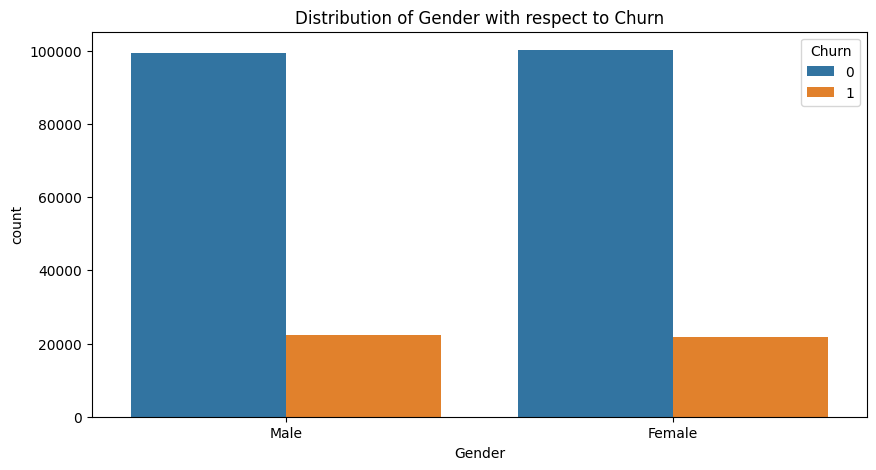

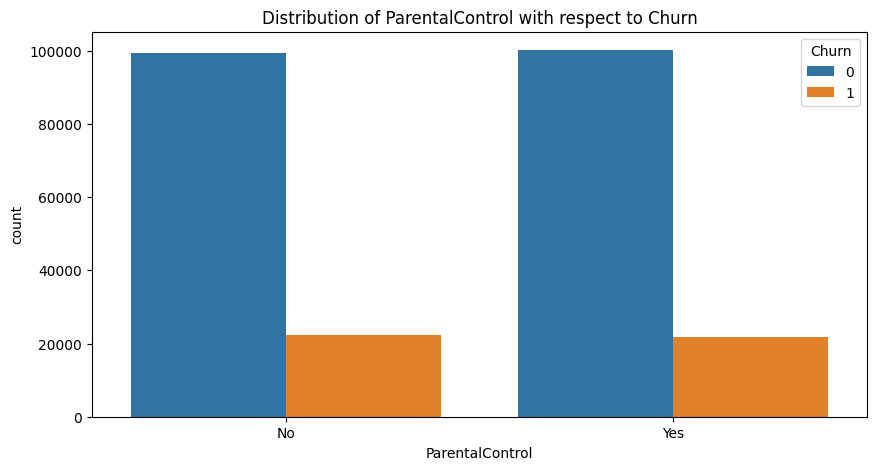

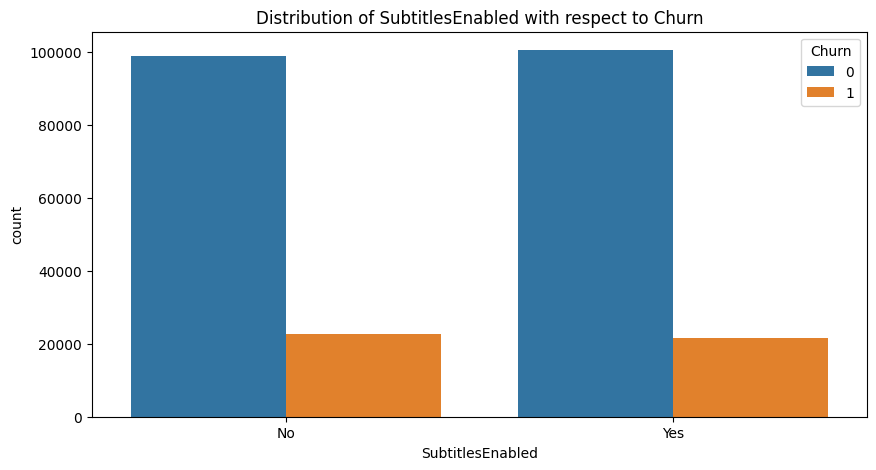


Train Dataset after Encoding:
   AccountAge  MonthlyCharges  TotalCharges  SubscriptionType  PaymentMethod  \
0          20       11.055215    221.104302                 1              3   
1          57        5.175208    294.986882                 0              1   
2          73       12.106657    883.785952                 0              3   
3          32        7.263743    232.439774                 0              2   
4          57       16.953078    966.325422                 1              2   

   PaperlessBilling  ContentType  MultiDeviceAccess  DeviceRegistered  \
0                 0            0                  0                 1   
1                 1            1                  0                 3   
2                 1            1                  0                 0   
3                 0            2                  0                 3   
4                 1            2                  0                 2   

   ViewingHoursPerWeek  ...  ContentDownloadsPerM

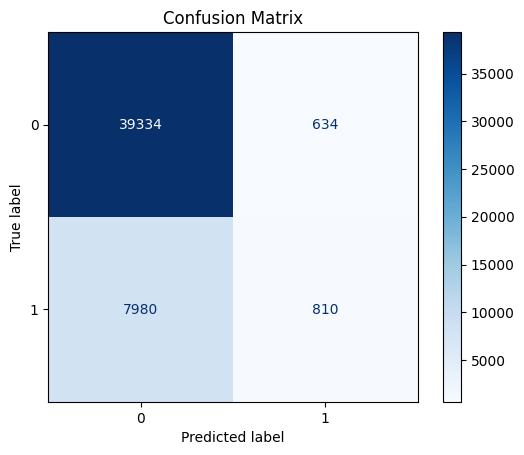

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic dataset information and summary statistics
print("Train Dataset Information:")
train_df.info()  # Show information about train dataset
print("\nTest Dataset Information:")
test_df.info()  # Show information about test dataset

print("\nTrain Dataset Summary Statistics:")
print(train_df.describe(include='all'))  # Summary statistics of train dataset
print("\nTest Dataset Summary Statistics:")
print(test_df.describe(include='all'))  # Summary statistics of test dataset

# Handle missing values by dropping rows with any missing data
train_df = train_df.dropna()
test_df = test_df.dropna()

# Display missing value counts (should be zero after dropping)
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())

# Display the first few rows of the datasets
print("\nFirst few rows of Train Dataset:")
print(train_df.head())
print("\nFirst few rows of Test Dataset:")
print(test_df.head())

# Visualize the relationship between 'AccountAge' and 'Churn'
plt.bar(train_df['AccountAge'].head(100), train_df['Churn'].head(100))
plt.xlabel('Account Age')
plt.ylabel('Churn')
plt.title('Account Age vs Churn')
plt.show()

# Visualize categorical features with respect to 'Churn'
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns
for feature in categorical_features:
    if feature != 'CustomerID':  # Exclude 'CustomerID'
        plt.figure(figsize=(10, 5))
        sns.countplot(x=feature, hue='Churn', data=train_df)
        plt.title(f'Distribution of {feature} with respect to Churn')
        plt.show()

# Encode categorical variables in both train and test datasets
label_encoders = {}
for column in train_df.select_dtypes(include=['object']).columns:
    if column != 'CustomerID':  # Exclude 'CustomerID'
        label_encoders[column] = LabelEncoder()
        train_df[column] = label_encoders[column].fit_transform(train_df[column])
        test_df[column] = label_encoders[column].transform(test_df[column])

# Display encoded data
print("\nTrain Dataset after Encoding:")
print(train_df.head())
print("\nTest Dataset after Encoding:")
print(test_df.head())

# Check class distribution in the target variable 'Churn'
print("\nClass Distribution in Training Set:")
print(train_df['Churn'].value_counts())

# Split the data into features and target variable
X = train_df.drop(columns=['Churn', 'CustomerID'])
y = train_df['Churn']

# Split the training data into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_df.drop(columns=['CustomerID']))

# Build and train the RandomForest model
model = RandomForestClassifier(random_state=82)
model.fit(X_train, y_train)

# Make predictions on the validation set and calculate AUC-ROC score
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
val_auc_score = roc_auc_score(y_val, y_val_pred_proba)
print(f'Validation AUC-ROC Score: {val_auc_score}')

# Make predictions on the test set
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Prepare the prediction DataFrame for submission
prediction_df = pd.DataFrame({
    'CustomerID': test_df['CustomerID'],
    'predicted_probability': y_test_pred_proba
})

# Save the predictions to a CSV file
prediction_df.to_csv('prediction_submission.csv', index=False)

# Final assertion checks to ensure correct output
assert isinstance(prediction_df, pd.DataFrame), 'Output should be a DataFrame named prediction_df.'
assert prediction_df.columns[0] == 'CustomerID', 'The first column name should be CustomerID.'
assert prediction_df.columns[1] == 'predicted_probability', 'The second column name should be predicted_probability.'
assert prediction_df.shape[1] == 2, 'The DataFrame should have exactly 2 columns.'

print("Prediction submission file created successfully!")

# Calculate and display the confusion matrix for validation set predictions
y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()
